# Conformal prediction for wind speed forecasting
This notebook goes through the training and testing of conformal predictors for wind speed forecasting as well as a Quantile Random Forest regressor for reference. 

In [1]:
import numpy as np
from data.dataimport import dataimport
from models.conformal_nex import Conformal_nex
from models.conformal_nxg import Conformal_nxg
from models.conformal_std import Conformal_std
from models.forest_qr import RanForestQuantile
import matplotlib.pyplot as plt
from mod_tr_schedule import train_schedule, crps
from scipy.stats import beta

In [ ]:
x = np.array(np.linspace(0, 20, num=200)).reshape(1,-1)
print(x.shape)
label = np.array([5])
score = crps(x,label)
print(score)

In [ ]:
a = np.arange(0,3,0.5)
print(a[:-1])
print(a[1:])
print(np.sum((np.power(a[:-1],2)+np.power(a[1:],2))*(a[1:]-a[:-1])/2))


In [ ]:
length = 5000
num_obs = 10
distr = beta.ppf(np.linspace(0,1,num=length),2,5)
preds = np.empty((num_obs,length))
obs = np.array([0.149, 0.095, 0.287, 0.355, 0.226, 0.192, 0.214, 0.734, 0.572, 0.084])
for i in range(num_obs):
    print(crps(distr.reshape(1,-1), obs[i].reshape(1,-1)))



In [ ]:
x = np.linspace(0, 20, num=200)
y = np.sin(x)
xv = np.linspace(0,20,num=10)
yterp = np.interp(xv,x,y)
plt.plot(x,y,'o')
plt.plot(xv,yterp,'x')
print(x[x > 4])

## Training schedule
We use a training schedule for testing the models. It works by splitting the data into a number of different trianing / validation data configurations. It then runs each desired model through all configurations. The one making the best predictions on the validation data will be trained on all the data before making the next prediction. The prediction is saved as a result before the corresponding data point is added to the training set and the process is ran again. This tries to mimic what one would actually do in the real world, meaning that each test point can be predicted with different hyper-parameters. The data splitting and model choice implementations can be found in `mod_tr_schedule.py` for a detailed view. However in general it works in the following:
1. Number of splits $k$ and confidence-level $c$ is passed together with data and model (parameters)
2. For each set of model-parameters
    1. Train model on $\frac{1}{1-c} + 1$ points to esnure non-infinite prediciton
    2. Predict the value of every $k$:th point there after and train the model in between
    3. Shift the points to predict with one step and run through data-set again
    4. Repeat until the model has run through the training-set $k$ times
3. Determine which set of model-parameters performs best on the validation data through some scoring scheme
4. Train that model on all the training data and predict the next test-point
5. Add the prediction as a result and add the next test-point to the training set
6. Repeat for all test-points

The scoring scheme $S$ currently implemented is 

$S(M,X,Y) = a|c - \frac{1}{n} \sum_{i=1}^{n} \mathbb{1}_{M_i(X_i)}(Y_i)| + b \frac{1}{n} \sum_{i=1}^{n}w(M_i(X_i))$ 

where $M$ are the models with inputs $X$, labels $Y$, validation-point indicies $i \in [1,n]$. The function $w(x)$ represents the width of interval/set $x$. The parameters $a$ and $b$ are currently chosen as $1000$ and $1$ respectively.

# Simulation
To start we simulate some data to ensure correctness of the implementation.  In this case we simulate a series defined by the random variable

$Y = X_{1} - 0.5 X_{2} + X_3 $

with $X_i \in \mathcal{N}(0,1)$. The systems get $X_1$ and $X_2$ as input and the conformal preictors get $X_{1} - 0.5 X_{2}$ as the underlying model output.

In [ ]:
num_training = 100
num_testing = 200
noise_vec = np.random.normal(0,1,(num_training+num_testing,3))
pol = np.array([1, -0.5])
y_train, y_test = noise_vec[:num_training,:2] @ pol + noise_vec[:num_training,2], noise_vec[num_training:,:2] @ pol + noise_vec[num_training:,2]
x_train, x_test = noise_vec[:num_training,:2], noise_vec[num_training:,:2]
yhat_train, yhat_test = noise_vec[:num_training,:2] @ pol, noise_vec[num_training:,:2] @ pol
plt.plot(y_test, label = 'y')
plt.plot(yhat_test, label = 'y_hat')
plt.axis([0,100,-5,5])
plt.legend()


# Conformal predictor
This is the "standard" implementation of the conformal predictor. It uses the crepes library developed by Henrik Boström at KTH. Currently the "normalized" version is used with default values for generating the difficulty estimates. See Crepes [Github](https://github.com/henrikbostrom/crepes) page for detailed information about the library.

Note: the variable mod_params is a list of dictionaries that are passed to the model constructors. It should contain all the versions of the models we wish to test. This is the case for all models in the module.

In [ ]:
mod_params = [{'window_length':np.inf},{'window_length':100}]
pred, mods = train_schedule(Conformal_std, mod_params, x_train, np.expand_dims(yhat_train,1), np.expand_dims(y_train,1), x_test, np.expand_dims(yhat_test,1), np.expand_dims(y_test,1), num_splits=5, block_training=True)
#print("Accuracy: " + str(np.sum((np.squeeze(y_test) > pred[:,0]) & (np.squeeze(y_test) < pred[:,1]))/len(y_test)))
#print("Mean width: " + str(np.mean(pred[:,1]-pred[:,0])))

In [ ]:
plt.plot(y_test, label = 'y')
plt.plot(yhat_test, label = 'y_hat')
plt.fill_between(range(len(y_test)),pred[:,0], y2 = pred[:,1], alpha = 0.3, label = 'PI')
plt.axis([num_testing-100,num_testing,-5,5])
plt.legend()

# Quantile random forest
The quantile random forest is a generalisation of the random forest algorithm used to predict quantiles. The algorithm used here is taken from this [Github](https://github.com/zillow/quantile-forest). Since the aglorithm is based on making feature selection for the decision trees it will likely not perform ideally on data-sets with very few features as the simulated one. Thus it is probably not optimal for the simulated dataset here, which might explain the poor performance below (we want an accuracy of 0.9). It is also incredibly slow to train in the current implementation why the sample size thus far has been very small. 

In [ ]:
mod_params = [{'num_trees':100, 'window_length':np.inf}, {'num_trees':80,'window_length':50}]
pred, mods = train_schedule(RanForestQuantile, mod_params, np.concatenate((x_train,np.expand_dims(yhat_train,1)),axis=1), np.expand_dims(yhat_train,1), np.expand_dims(y_train,1), np.concatenate((x_test,np.expand_dims(yhat_test,1)),axis=1), np.expand_dims(yhat_test,1), np.expand_dims(y_test,1), num_splits=5, confidence=0.9, block_training=True)
print("Accuracy: " + str(np.sum((np.squeeze(y_test) > pred[:,0]) & (np.squeeze(y_test) < pred[:,1]))/len(y_test)))
print("Mean width: " + str(np.mean(pred[:,1]-pred[:,0])))

In [ ]:
plt.plot(y_test, label = 'y')
plt.plot(yhat_test, label = 'y_hat')
plt.fill_between(range(len(y_test)),pred[:,0], y2 = pred[:,1], alpha = 0.3, label = 'PI')
plt.axis([num_testing-100,num_testing,-5,5])
plt.legend()

#### Next simulation
We create more simulation points here since the coming algorithms are a lot faster.

In [ ]:
num_training = 300
num_testing = 1000
noise_vec = np.random.normal(0,1,(num_training+num_testing,3))
pol = np.array([1, -0.5])
y_train, y_test = noise_vec[:num_training,:2] @ pol + noise_vec[:num_training,2], noise_vec[num_training:,:2] @ pol + noise_vec[num_training:,2]
x_train, x_test = noise_vec[:num_training,:2], noise_vec[num_training:,:2]
yhat_train, yhat_test = noise_vec[:num_training,:2] @ pol, noise_vec[num_training:,:2] @ pol

## Non-exchangeable conformal predictor
This is the non-exchangeable split conformal predictor described in [this article](https://arxiv.org/abs/2202.13415) by Barber et. al., assuming that the undelying model is trained on other data. It currently allows one to change the forget factor as model input. The conformity scores here are only based on the residuals of the predictions.

In [ ]:
mod_params = [{'forget_factor':1},{'forget_factor':0.99}, {'forget_factor':0.98}]
pred, mods = train_schedule(Conformal_nex, mod_params, x_train, yhat_train, y_train, x_test, yhat_test, y_test, num_splits=5, confidence=0.9, block_training=False)
print("Accuracy: " + str(np.sum((np.squeeze(y_test) > pred[:,0]) & (np.squeeze(y_test) < pred[:,1]))/len(y_test)))
print("Mean width: " + str(np.mean(pred[:,1]-pred[:,0])))

In [ ]:
plt.plot(y_test, label = 'y')
plt.plot(yhat_test, label = 'y_hat')
plt.fill_between(range(len(y_test)),pred[:,0], y2 = pred[:,1], alpha = 0.3, label = 'PI')
plt.axis([num_testing-100,num_testing,-5,5])
plt.legend()

## Non-exchangeable conformal predictor with custom conformity score
This predictor is based on the same article as above but employs a custom conformity score described by

$\alpha_i = a |y_i - \hat{y}_i| - \mathbf{w}^T \mathbf{V(x_i)}$ 

where $\mathbf{V(x_i)}$ is the variance of each variable in the ensemble input and $a$ and $\mathbf{w}$ are weights passed as model parameters. The thought is that the larger the varaince the more uncertain a prediction should be. This is especially tuned for an ensemble type system so it might prove less good for the simulated data.

In [ ]:
mod_params = [{'forget_factor':1, 'resid_factor':1, 'input_factor': np.array([0]), 'num_input_vars':1},{'forget_factor':0.99, 'resid_factor':0.9, 'input_factor': np.array([0.1]), 'num_input_vars':1}, {'forget_factor':0.98, 'resid_factor':0.9, 'input_factor': np.array([0.1]),'num_input_vars':1}]
pred1, mods = train_schedule(Conformal_nxg, mod_params, x_train, yhat_train, y_train, x_test, yhat_test, y_test, num_splits=5, confidence=0.9)
print("Accuracy: " + str(np.sum((np.squeeze(y_test) > pred1[:,0]) & (np.squeeze(y_test) < pred1[:,1]))/len(y_test)))
print("Mean width: " + str(np.mean(pred1[:,1]-pred1[:,0])))

In [ ]:
plt.plot(y_test, label = 'y')
plt.plot(yhat_test, label = 'y_hat')
plt.fill_between(range(len(y_test)),pred1[:,0], y2 = pred1[:,1], alpha = 0.3, label = 'PI')
plt.axis([num_testing-100,num_testing,-5,5])
plt.legend()

## The real data
The data split into three parts: the ensemble forecasts, the post-processed forecasts and the measured values of wind speed near or at Måseskär outside the west coast of Sweden. The forecasts comes from the Norwegian Meteorological Institute (MET) and their [public data](https://thredds.met.no/thredds/catalog.html) while the measurements comes from [SMHI](https://www.smhi.se/data/meteorologi/ladda-ner-meteorologiska-observationer/#param=wind,stations=core). The forecasts are 24-hour ahead collected at noon for four months between Septembre 2022 and January 2023. Points with missing post-processed forecasts, measured data or more than 25% of ensemble have been removed. Ensemble data with less than 25% missing values have been bootstrapped to compensate. The `fcdates` object is a list of reference dates. Each data object are split into two, one for intial training and one for testing, dates for the split can be found in the `dataimport.py` file.

In [2]:
inp_data, forecasts, measurements, fcdates = dataimport()
print(str(fcdates[0][0]) + " - " + str(fcdates[0][-1]))
print(str(fcdates[1][0]) + " - " + str(fcdates[1][-1]))


2022-01-02 12:00:00 - 2022-03-01 12:00:00
2022-03-02 12:00:00 - 2023-01-23 12:00:00


Text(0, 0.5, 'wind speed')

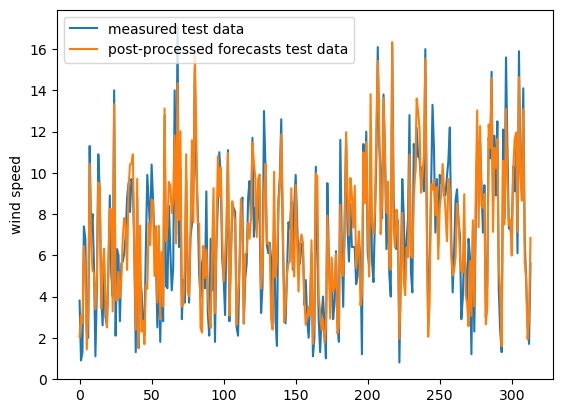

In [3]:
plt.plot(measurements[1],label = 'measured test data')
plt.plot(forecasts[1],label = 'post-processed forecasts test data')
plt.legend()
plt.ylabel('wind speed')

### Standard conformal

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.34557879e-02 3.34576348e-02
 5.34594817e-02 7.49749243e-02 1.22726025e-01 1.70477126e-01
 2.18228228e-01 2.63690920e-01 3.06197750e-01 3.48704580e-01
 3.91211411e-01 4.26340886e-01 4.59830949e-01 4.93321013e-01
 5.26886790e-01 5.60755423e-01 5.94624057e-01 6.28492690e-01
 6.47237343e-01 6.55111636e-01 6.62985928e-01 6.70860221e-01
 6.97568862e-01 7.24988233e-01 7.52407604e-01 7.93161003e-01
 8.59178874e-01 9.25196746e-01 9.91214617e-01 1.04074392e+00
 1.08409001e+00 1.12743609e+00 1.16655676e+00 1.17116983e+00
 1.17578290e+00 1.18039598e+00 1.19987569e+00 1.23477266e+00
 1.26966963e+00 1.304566

(0.0, 10.0, 0.0, 1.0)

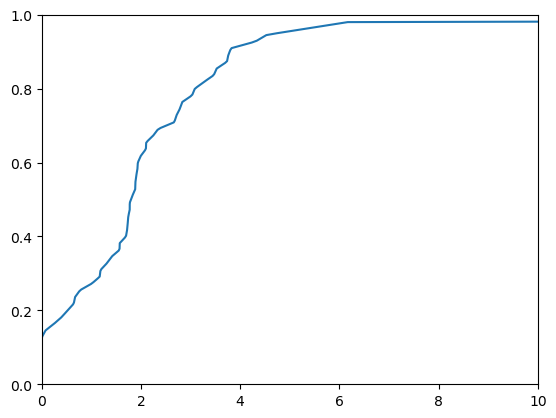

In [3]:
conf_std = Conformal_std()
conf_std.calibrate(inp_data[0],forecasts[0],measurements[0])
pred = conf_std.predict(inp_data[1][0,:],forecasts[1][0])
plt.plot(pred,np.linspace(0,1,len(pred)))
print(pred)
print(forecasts[0].shape)
plt.axis([0,10,0,1])

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.97753590e-02 4.66495648e-02 7.35237706e-02 1.00397976e-01
 2.81235267e-01 4.65033387e-01 6.48831506e-01 8.03480187e-01
 8.58534952e-01 9.13589716e-01 9.68644481e-01 1.03546863e+00
 1.11547449e+00 1.19548034e+00 1.27548620e+00 1.31872798e+00
 1.34745762e+00 1.37618726e+00 1.40491691e+00 1.47940976e+00
 1.55569725e+00 1.63198475e+00 1.69669913e+00 1.71722527e+00
 1.73775141e+00 1.75827755e+00 1.79663959e+00 1.85655335e+00
 1.91646710e+00 1.97638085e+00 2.01629729e+00 2.04756625e+00
 2.07883521e+00 2.11010416e+00 2.11499755e+00 2.11830841e+00
 2.12161927e+00 2.12728106e+00 2.14305183e+00 2.15882260e+00
 2.17459337e+00 2.19145727e+00 2.20974700e+00 2.22803673e+00
 2.24632646e+00 2.29027047e+00 2.34632900e+00 2.40238754e+00
 2.45844607e+00 2.49875273e+00 2.53777353e+00 2.57679432e+00
 2.61316645e+00 2.636589

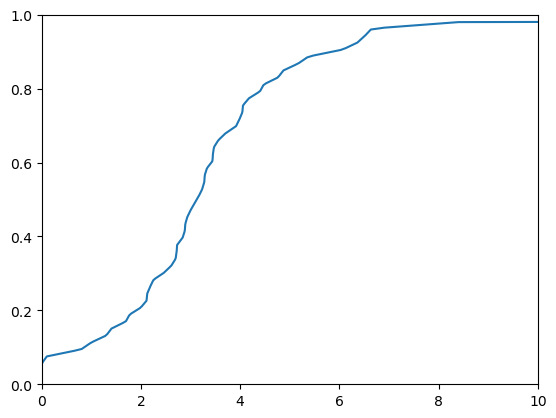

In [3]:
conf_std = Conformal_nex(0.99)
conf_std.calibrate(inp_data[0],forecasts[0],measurements[0])
pred = conf_std.predict(inp_data[1][1,:],forecasts[1][1])
plt.plot(pred,np.linspace(0,1,len(pred)))
plt.axis([0,10,0,1])
print(pred)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.20785052e-02 9.92621148e-02 1.56445724e-01 2.13629334e-01
 3.63057166e-01 5.14258924e-01 6.65460683e-01 7.98553169e-01
 8.69772303e-01 9.40991438e-01 1.01221057e+00 1.07874780e+00
 1.14004130e+00 1.20133480e+00 1.26262829e+00 1.30562280e+00
 1.34139403e+00 1.37716526e+00 1.41293649e+00 1.47666864e+00
 1.54149729e+00 1.60632595e+00 1.66417761e+00 1.69538984e+00
 1.72660207e+00 1.75781430e+00 1.80081819e+00 1.85807033e+00
 1.91532247e+00 1.97257461e+00 2.00744177e+00 2.03262895e+00
 2.05781613e+00 2.08300331e+00 2.09228879e+00 2.10062016e+00
 2.10895153e+00 2.12196071e+00 2.15508444e+00 2.18820817e+00
 2.22133190e+00 2.24925115e+00 2.27038193e+00 2.29151272e+00
 2.31264350e+00 2.34192518e+00 2.37505590e+00 2.40818661e+00
 2.44131733e+00 2.48165890e+00 2.52258910e+00 2.56351931e+00
 2.60055118e+00 2.618524

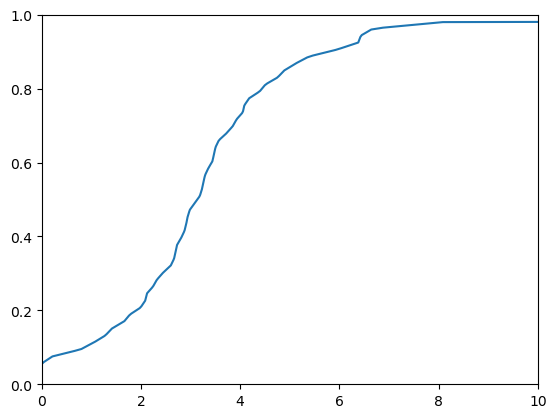

In [3]:
conf_std = Conformal_nxg(0.99,0.95,np.array([0.01, 0.01]),2)
conf_std.calibrate(inp_data[0],forecasts[0],measurements[0])
pred = conf_std.predict(inp_data[1][1,:],forecasts[1][1])
plt.plot(pred,np.linspace(0,1,len(pred)))
plt.axis([0,10,0,1])
print(pred)

(200,)
[  0.        0.        0.        0.34475   0.693     0.7       0.7
   0.7       0.7       0.7       0.7       0.7       0.7       0.7
   0.7       0.93125   1.18      2.115     3.11      3.2       3.2
   3.2       3.2       3.2       3.2       3.2       3.2       3.67575
   4.223     4.3       4.3       4.3       4.3       4.50875   4.7575
   4.8       4.8       4.8       4.8       4.8       4.8       4.8
   4.8       4.8       4.8       4.8       4.8       4.99125   5.24
   5.33775   5.3875    5.73525   6.183     6.3       6.3       6.3
   6.3       6.3       6.3       6.3       6.3       6.3       6.3
   6.3       6.3       6.53625   6.8845    7.        7.        7.
   7.        7.        7.        7.        7.        7.09375   7.243
   7.3       7.3       7.3       7.3       7.3       7.3       7.3
   7.3       7.3       7.3       7.3565    7.456     7.5       7.5
   7.5       7.5       7.5       7.5       7.5       7.5       7.5
   7.5       7.5       7.5       7.5       7.5

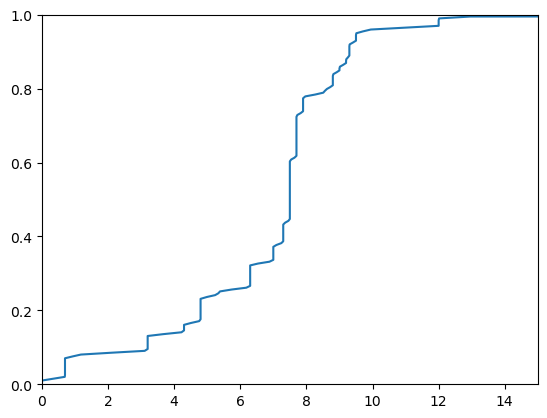

In [4]:
qrf = RanForestQuantile()
qrf.calibrate(inp_data[0],forecasts[0],measurements[0])
pred = qrf.predict(np.squeeze(inp_data[1][0,:]),np.squeeze(forecasts[1][0]))
plt.plot(pred,np.linspace(0,1,len(pred)))
plt.axis([0 ,15,0,1])
print(pred.shape)
print(pred)

In [4]:
mod_params = [{'window_length':np.inf}, {'window_length':100}, {'window_length':50}]
pred, mods = train_schedule(Conformal_std, mod_params, inp_data[0], forecasts[0], measurements[0], inp_data[1], forecasts[1], measurements[1], num_splits=5, block_training=True)
#print('Accuracy: ' + str(np.sum((np.squeeze(measurements[1]) > pred[:,0]) & (np.squeeze(measurements[1]) < pred[:,1]))/len(measurements[1])))
#print('Width: ' + str(np.mean(pred[:,1]-pred[:,0])))

100%|██████████| 314/314 [02:03<00:00,  2.55it/s]


0.8821528728188229


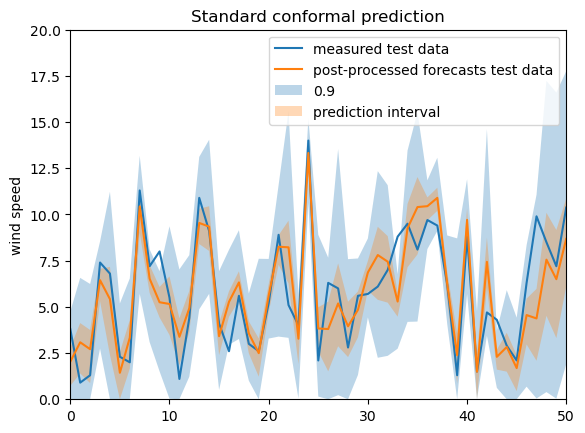

In [6]:
plt.plot(measurements[1],label = 'measured test data')
plt.plot(forecasts[1],label = 'post-processed forecasts test data')
plt.fill_between(range(len(measurements[1])),pred[:,9], y2 = pred[:,189], alpha = 0.3, label = '0.9')
plt.fill_between(range(len(measurements[1])),pred[:,49], y2 = pred[:,149], alpha = 0.3, label = 'prediction interval')
plt.legend()
plt.ylabel('wind speed')
plt.title('Standard conformal prediction')
plt.axis([0, 50, 0, 20])
print(crps(pred,measurements[1]))


### Non-exchangeable conformal prediction

In [8]:
mod_params = [ {'forget_factor':1},{'forget_factor':0.995}, {'forget_factor':0.99}, {'forget_factor':0.98}, {'forget_factor':0.97}, {'forget_factor':0.96}, {'forget_factor':0.95}]
pred, mods = train_schedule(Conformal_nex, mod_params, inp_data[0], forecasts[0], measurements[0], inp_data[1], forecasts[1], measurements[1], num_splits=5)
#print('Accuracy: ' + str(np.sum((np.squeeze(measurements[1]) > pred[:,0]) & (np.squeeze(measurements[1]) < pred[:,1]))/len(measurements[1])))
#print('Width: ' + str(np.mean(pred[:,1]-pred[:,0])))

  0%|          | 0/314 [00:00<?, ?it/s]/Users/simonalthoff/dev/exjobb/wind-conformal/mod_tr_schedule.py:20: RuntimeWarning: invalid value encountered in subtract
  up_score = np.sum((np.power((f_up[:-1]-1),2)+np.power((f_up[1:]-1),2))*(up[1:]-up[:-1]))/2
  1%|          | 2/314 [00:00<00:41,  7.59it/s]/opt/homebrew/Caskroom/miniforge/base/envs/thesis/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
100%|██████████| 314/314 [09:19<00:00,  1.78s/it]


In [ ]:
plt.plot(measurements[1],label = 'measured test data')
plt.plot(forecasts[1],label = 'post-processed forecasts test data')
plt.fill_between(range(len(measurements[1])),pred[:,9], y2 = pred[:,189], alpha = 0.3, label = '0.9')
plt.fill_between(range(len(measurements[1])),pred[:,49], y2 = pred[:,149], alpha = 0.3, label = '')
plt.legend()
plt.ylabel('wind speed')
plt.title('Standard conformal prediction')
plt.axis([0, 50, 0, 20])
print(crps(pred,measurements[1]))

### Non-exchangeable conformal prediction with custom conformity

In [ ]:
mod_params = [{'forget_factor':1, 'resid_factor':0.95, 'input_factor': np.array([0.05, 0.05]), 'num_input_vars':2},{'forget_factor':0.99, 'resid_factor':0.95, 'input_factor': np.array([0.05, 0.05]), 'num_input_vars':2}, {'forget_factor':0.99, 'resid_factor':0.9, 'input_factor': np.array([0.1, 0.1]),'num_input_vars':2}, {'forget_factor':0.99, 'resid_factor':0.89, 'input_factor': np.array([0.08, 0.08]),'num_input_vars':2}]
pred, mods = train_schedule(Conformal_nxg, mod_params, inp_data[0], forecasts[0], measurements[0], inp_data[1], forecasts[1], measurements[1], num_splits=5, confidence=0.9)
print('Accuracy: ' + str(np.sum((np.squeeze(measurements[1]) > pred[:,0]) & (np.squeeze(measurements[1]) < pred[:,1]))/len(measurements[1])))
print('Width: ' + str(np.mean(pred[:,1]-pred[:,0])))

In [ ]:
plt.plot(measurements[1],label = 'measured test data')
plt.plot(forecasts[1],label = 'post-processed forecasts test data')
plt.fill_between(range(len(measurements[1])),pred[:,0], y2 = pred[:,1], alpha = 0.3, label = 'prediction interval')
plt.legend()
plt.ylabel('wind speed')
plt.title('Non-exchangeable conformal prediction custom conformity')

## Quantile random forest
Here we have about 60 features instead of 3 so the QRF is more suitable I would say than on the simulated data.

In [ ]:
mod_params = [{'num_trees':200,'window_length':100}, {'num_trees':100,'window_length':np.inf}, {'num_trees':80,'window_length':50}]
pred, mods = train_schedule(RanForestQuantile, mod_params, inp_data[0], forecasts[0], measurements[0], inp_data[1], forecasts[1], measurements[1], num_splits=5, confidence=0.9, block_training=True)
print('Accuracy: ' + str(np.sum((np.squeeze(measurements[1]) > pred[:,0]) & (np.squeeze(measurements[1]) < pred[:,1]))/len(measurements[1])))
print('Width: ' + str(np.mean(pred[:,1]-pred[:,0])))

In [ ]:
plt.plot(measurements[1],label = 'measured test data')
plt.plot(forecasts[1],label = 'post-processed forecasts test data')
plt.fill_between(range(len(measurements[1])),pred[:,0], y2 = pred[:,1], alpha = 0.3, label = 'prediction interval')
plt.legend()
plt.ylabel('wind speed')
plt.title('Quantile random forest prediction')